用回归分析进行房价预测是kaggle竞赛中一个经典的案例。回归分析在房价预测中有广泛的运用。我们利用几个数据集来实现一个岭回归的简单演示。这个数据集是华盛顿的Kung country的房价数据集，我们来建立一个回归模型来实现房价的预测。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 
              'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float,
              'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 
              'yr_built':int,'id':str, 'sqft_lot':int, 'view':int}

In [3]:
sales = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict) #导入数据
sales = sales.sort(['sqft_living','price'])  # 按照房屋面积排序

C:\Users\lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [4]:
print "sales data shape:", sales.shape

sales data shape: (9761, 21)


In [5]:
sales.head()  #数据展示

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8840,3980300371,20140926T000000,142000.0,0.0,0.00,290.0,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620.0,22850.0
6982,2856101479,20140701T000000,276000.0,1.0,0.75,370.0,1801,1.0,0,0,...,5,370,0,1923,0,98117,47.6778,-122.389,1340.0,5000.0
8338,1222029077,20141029T000000,265000.0,0.0,0.75,384.0,213444,1.0,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920.0,224341.0
2228,6896300380,20141002T000000,228000.0,0.0,1.00,390.0,5900,1.0,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170.0,6000.0
9631,9266700190,20150511T000000,245000.0,1.0,1.00,390.0,2000,1.0,0,0,...,6,390,0,1920,0,98103,47.6938,-122.347,1340.0,5100.0


可以看出，这个数据集包含9761条记录，而且每条房价数据都包含多个属性。例如

price        房价

bedrooms     卧室数量

bathrooms    浴室数量

sqft_living  居住面积

...          ...

等等

In [6]:
sales.price.describe() #房价数据描述

count    9.761000e+03
mean     5.427350e+05
std      3.795276e+05
min      8.000000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.490000e+05
max      7.700000e+06
Name: price, dtype: float64

可以看出，房价数据的均值，标准差，最大值，最小值等。

接下来，我们需要了解房价数据的分布。绘制直方图如下。

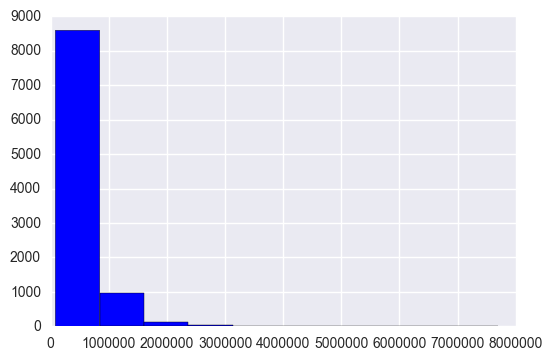

In [7]:
plt.hist(sales.price, color='blue')
plt.show()

In [8]:
numeric_features = sales.select_dtypes(include=[np.number])  #找出数值型变量
numeric_features.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot           int32
floors           float64
waterfront         int32
view               int32
condition          int32
grade              int32
sqft_above         int32
sqft_basement      int32
yr_built           int32
yr_renovated       int32
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

In [9]:
corr = numeric_features.corr()        #计算这些变量之间的相关系数

print  corr['price'].sort_values(ascending=False)[:5], '\n'   #输出和房价正相关性最高的5个因素
print  corr['price'].sort_values(ascending=False)[-5:]        #输出和房价相关性最低的5个因素

price            1.000000
sqft_living      0.705052
grade            0.665567
sqft_above       0.611453
sqft_living15    0.584807
Name: price, dtype: float64 

sqft_lot      0.094143
sqft_lot15    0.077943
yr_built      0.051759
condition     0.044732
long          0.023754
Name: price, dtype: float64


可以看出，和房价（price）相关性最大的因素为房屋面积（sqft_living）。
进一步，为了更加清楚的了解变量之间的相关性，我们可以绘制出相关系数矩阵。

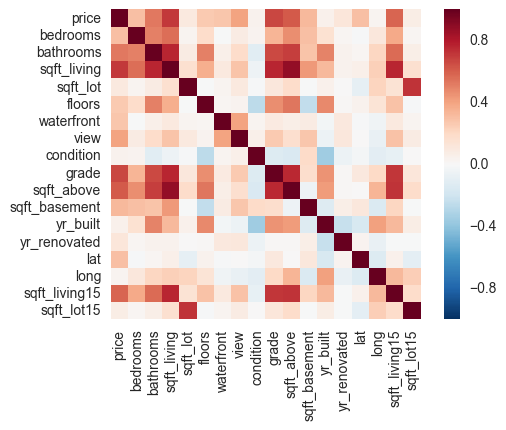

In [10]:
corr = numeric_features.corr()        #计算这些变量之间的相关系数
sns.heatmap(corr, vmax=1, square=True);   #相关系数矩阵
plt.show()

带有相关性系数的矩阵

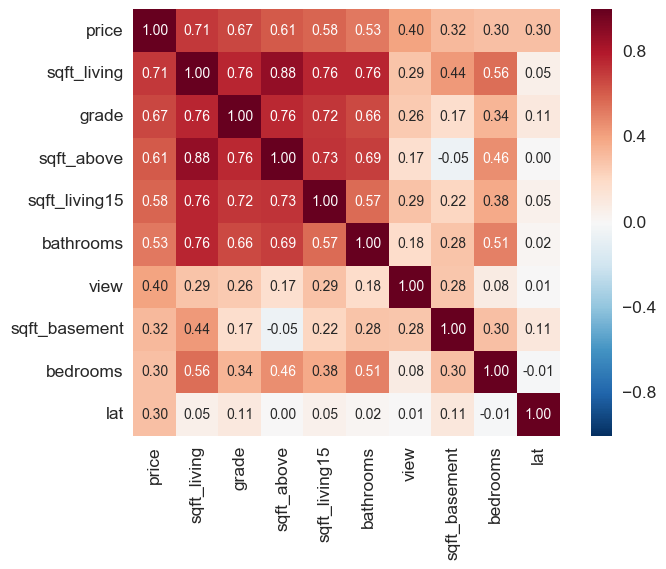

In [11]:
k = 10   #number of variables for heatmap
cols = corr.nlargest(k, 'price')['price'].index
cm = np.corrcoef(sales[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

从图中可以看出：
‘sqft_living’, ‘grade’ 以及 ‘sqft_above’ 与 ‘price’有很强的相关性。
‘sqft_living’ 和 ‘sqft_above’ 也是相关性比较强的变量， 即变量之间存在共线性，所以我们在模型中只需要其中的一个变量。
‘bedrooms’ 和 ‘price’相关性不强。

price和相关变量之间的散点图矩阵

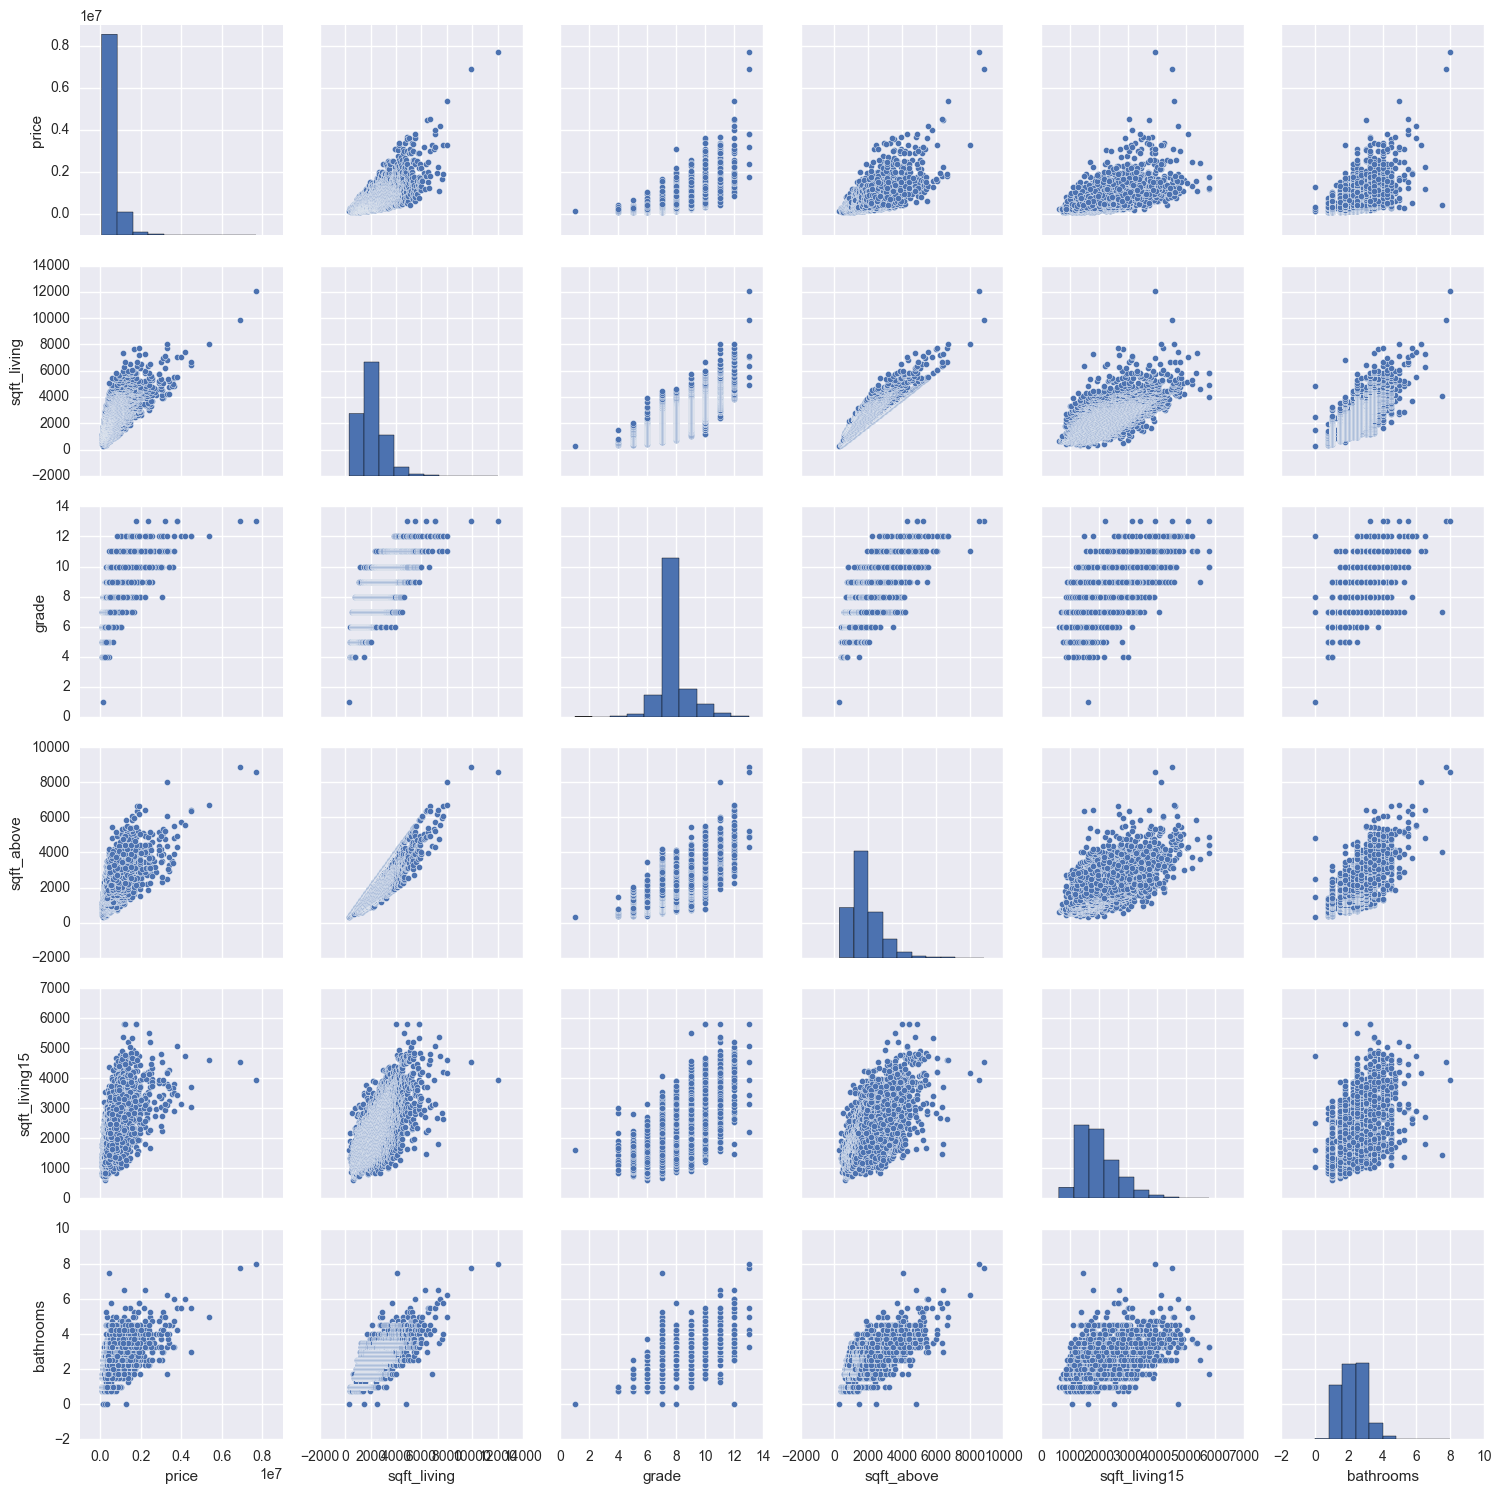

In [12]:
sns.set()
cols = ['price', 'sqft_living', 'grade','sqft_above', 'sqft_living15', 'bathrooms']
sns.pairplot(sales[cols])
plt.show()

这里，我们只是展现岭回归，简单起见，只建立房屋面积（sqft_living）单个因素和房价（price）之间的岭回归模型。

定义一个DataFrame类型的数据，存放自变量不同次方的数据。

In [13]:
def polynomial_dataframe(feature, degree): #定义一个DataFrame类型的数据，存储变量的不同乘方。
    poly_dataframe = pd.DataFrame()
    poly_dataframe['power_1'] = feature  #数据的一次方等于原数据
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)  #命名
            poly_dataframe[name] = poly_dataframe['power_' + str(power-1)] *feature  
    return poly_dataframe

我们先设置一个比较小的岭参数，来实现岭回归。

In [14]:
l2_small_penalty=1e-9

[  3.99586476e+02  -3.00291414e-01   1.67342377e-04  -4.91388692e-08
   8.45442338e-12  -5.48437891e-16  -3.38756966e-20   2.76116528e-24
   3.03647383e-28   4.95829168e-33  -1.16141287e-36  -1.27517440e-40
  -6.17786000e-45   1.06893655e-49   6.38542356e-53]
95584.2256262


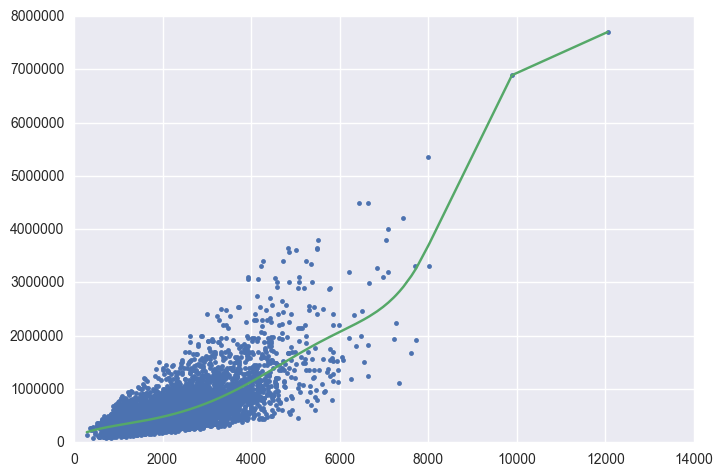

In [15]:
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)   
model = linear_model.Ridge(alpha=l2_small_penalty, normalize=True)  #以l2_small_penalty=1e-9为岭参数实现岭回归
model.fit(poly15_data, sales['price'])
print model.coef_   #输出模型
print model.intercept_   #输出截距

plt.plot(sales['sqft_living'],sales['price'],'.',sales['sqft_living'], model.predict(poly15_data),'-')  
plt.show()

和一般的线性回归不同，岭回归引入了正则化参数来“缩减”相关系数。为了直观的感受岭回归中惩罚项的作用，接下来我们设置一个较大的岭参数，利用同一个数据集，重新建立岭回归模型。

In [16]:
l2_large_penalty=1.23

[  7.12812307e+01   1.20119148e-02   1.48611872e-06   1.06902691e-10
   5.27414693e-15   2.15798926e-19   7.19021517e-24   8.78690451e-29
  -1.81095636e-32  -2.85525366e-36  -3.13308480e-40  -3.05205119e-44
  -2.81009380e-48  -2.50665922e-52  -2.19233921e-56]
300628.530734


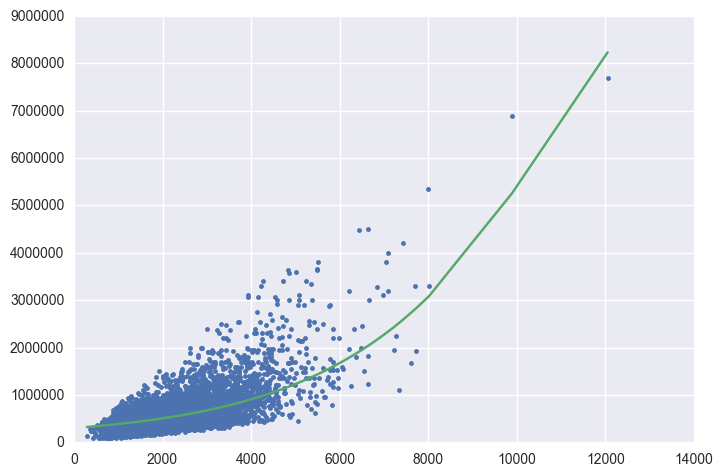

In [17]:
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)
model = linear_model.Ridge(alpha=l2_large_penalty, normalize=True)  #以l2_large_penalty=1.23为岭参数实现岭回归
model.fit(poly15_data, sales['price'])
print model.coef_  #输出模型
print model.intercept_  #输出截距

plt.plot(sales['sqft_living'],sales['price'],'.',sales['sqft_living'], model.predict(poly15_data),'-')
plt.show()

对比两次拟合的结果，我们发现，当岭参数较小时，一次项前的系数为3.99586476e+02，而当岭参数较大时，一次项前的回归系数为7.12812307e+01，可以看出，随着惩罚项作用的增强，回归系数的绝对值在减小。 

接下来，我们通过k折交叉验证来选择合适的岭参数。

In [18]:
train_valid_shuffled = pd.read_csv('kc_house_train_valid_shuffled.csv', dtype=dtype_dict) #重新导入一个数据集，利用这个数据集来进行10折交叉验证。
test = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)   # 导入测验集

根据k折交叉验证的思想，编写函数。

In [19]:
def k_fold_cross_validation(k, l2_penalty, data, output_name):  #定义k折交叉验证函数
    n = len(data)
    RSS=0
    for i in range(k):
        start = n*i/k  
        end = n*(i+1)/k     
        validation_set = data[start:end] #选择1/k的数据作为验证集
        first_t = data[0:start]
        second_t = data[end:n]
        train_set = first_t.append(second_t)  #剩余数据作为训练集
        model = linear_model.Ridge(alpha=l2_penalty, normalize=True)  #建立岭回归模型
        model.fit(train_set, train_set['price'])  
        predicted = model.predict(validation_set)
        err = predicted-validation_set[output_name]
        RSS += (err*err).sum()
    Rss = RSS/k  #取k次循环的平均误差
    return Rss  

取岭参数属于序列[10^3, 10^3.5, 10^4, 10^4.5, ..., 10^9]中的数据，我们通过交叉验证来选择最合适的岭参数。

2.64449176172e+14
2.65525075029e+14
2.65871201934e+14
2.659812601e+14
2.66016124304e+14
2.66027155422e+14
2.66030644378e+14
2.66031747743e+14
2.66032096664e+14
2.66032207003e+14
2.66032241896e+14
2.6603225293e+14
2.66032256419e+14


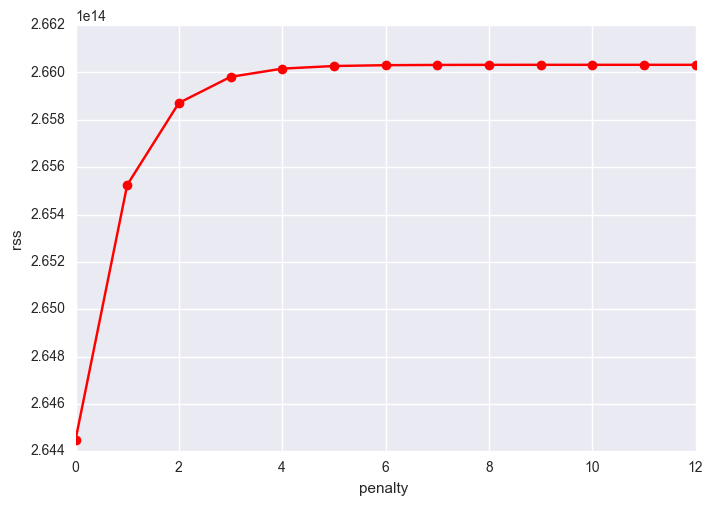

In [20]:
validata = polynomial_dataframe(train_valid_shuffled['sqft_living'],15)
validata['price'] = train_valid_shuffled['price']
penalty = np.logspace(3,9,num=13)  #岭参数
poly_dataSeries = np.zeros(13)
count= 0
for pen in penalty:
    rss = k_fold_cross_validation(10, pen, validata, 'price')
    poly_dataSeries[count] = rss
    count = count + 1
    print rss
    
plt.plot(np.arange(13),poly_dataSeries,'ro-')  #绘制rss变化曲线
plt.xlabel('penalty ')
plt.ylabel('rss')
plt.show()   

通过rss的变化过程，可以看出岭参数等于1000时，rss最小。因此，我们设定岭参数为1000，在数据集上重新训练我们最后的模型。

In [21]:
l2_penalty = 1000

In [22]:
poly15_data =polynomial_dataframe(train_valid_shuffled['sqft_living'], 15)
model_last = linear_model.Ridge(alpha=l2_penalty, normalize=True)
model_last.fit(poly15_data, train_valid_shuffled['price'])

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [23]:
test_data =polynomial_dataframe(test['sqft_living'], 15) 
pre = model_last.predict(test_data)
err = pre-test['price']
rss = (err*err).sum()
print rss  #输出测试集的误差

2.83856861224e+14
